1.) Use existing segments to create to generate more concise segments in a txt file

2.) Create video segments

3.) stitch together

to do next: need to generate captions for those more specific segments (see cooking_summary_method2.ipynb for next steps)

In [2]:
%pip install omegaconf
%pip install iopath
%pip install timm
%pip install decord
%pip install webdataset
%pip install einops
%pip install wandb
%pip install gradio
%pip install torchshow
%pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import argparse
import os
import random
import json
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchshow as ts
from timechat.common.config import Config
from timechat.common.dist_utils import get_rank
from timechat.common.registry import registry
from timechat.conversation.conversation_video import Chat, Conversation, default_conversation,SeparatorStyle, conv_llava_llama_2
import decord
import cv2
import time
import subprocess
from decord import VideoReader
from timechat.processors.video_processor import ToTHWC, ToUint8, load_video
decord.bridge.set_bridge('torch')

# imports modules for registration
from timechat.datasets.builders import *
from timechat.models import *
from timechat.processors import *
from timechat.runners import *
from timechat.tasks import *

import random as rnd
from transformers import StoppingCriteria, StoppingCriteriaList
from PIL import Image
import gradio as gr

/opt/conda/envs/timechat/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def parse_args():
    parser = argparse.ArgumentParser(description="Demo")
    parser.add_argument("--cfg-path", default='eval_configs/timechat.yaml', help="path to configuration file.")
    parser.add_argument("--gpu-id", type=int, default=0, help="specify the gpu to load the model.")
    parser.add_argument("--num-beams", type=int, default=1)
    parser.add_argument("--temperature", type=float, default=1.0)
    parser.add_argument("--text-query", default="What is he doing?", help="question the video")
    parser.add_argument("--video-path", default='examples/takeblood.mp4', help="path to video file.")
    parser.add_argument(
        "--options",
        nargs="+",
        help="override some settings in the used config, the key-value pair "
        "in xxx=yyy format will be merged into config file (deprecate), "
        "change to --cfg-options instead.",
    )
    args = parser.parse_args(args=[])
    return args

In [5]:
print('Initializing Chat')
args = parse_args()
cfg = Config(args)

DIR="ckpt/timechat"
MODEL_DIR=f"{DIR}/timechat_7b.pth"

model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_config.ckpt = MODEL_DIR
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda:{}'.format(args.gpu_id))
model.eval()

vis_processor_cfg = cfg.datasets_cfg.webvid.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)

Initializing Chat
Loading VIT


INFO:root:freeze vision encoder


Loading VIT Done
Loading Q-Former
use text input for Qformer


INFO:root:load checkpoint from ckpt/instruct-blip/instruct_blip_vicuna7b_trimmed.pth
INFO:root:freeze Qformer
INFO:root:Loading Q-Former Done
INFO:root:Loading LLAMA Tokenizer
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Using pad_token, but it is not set yet.
INFO:root:Loading LLAMA Model
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]
INFO:root:use gradient checkpointing for LLAMA
INFO:root:Loading LLAMA Done
INFO:root:Using LORA



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


INFO:root:Loading LLAMA proj
INFO:root:LLAMA proj is frozen
INFO:root:Loading llama_proj Done


trainable params: 0 || all params: 6,771,970,048 || trainable%: 0.0


INFO:root:video_Qformer is frozen


Load first Checkpoint: ckpt/timechat/timechat_7b.pth


In [9]:
chat = Chat(model, vis_processor, device='cuda:{}'.format(args.gpu_id))
print('Initialization Finished')

Initialization Finished


video path:  segmented_videos_highlight/takeblood/output_0.mp4


/opt/conda/envs/timechat/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


You are given a short segment from a medical procedural video. Provide a description of the main activity or event in the video.
In the video, there is an operation scene taking place.
video path:  segmented_videos_highlight/takeblood/output_1.mp4
You are given a short segment from a medical procedural video. Provide a description of the main activity or event in the video.
In the video, a medical professional is shown injecting a large quantity of a solution into a patient.
video path:  segmented_videos_highlight/takeblood/output_2.mp4
You are given a short segment from a medical procedural video. Provide a description of the main activity or event in the video.
In the video, a man is showing how to perform bleeding management after a blood collection. He uses gauze pads and tape to cover and wrap up the injured area.
video path:  segmented_videos_highlight/takeblood/output_3.mp4
You are given a short segment from a medical procedural video. Provide a description of the main activity 

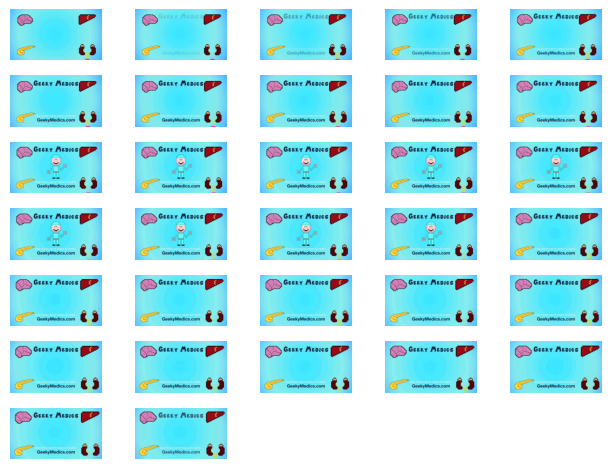

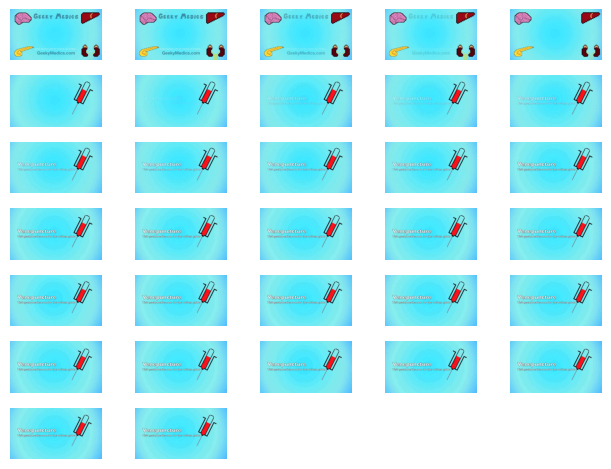

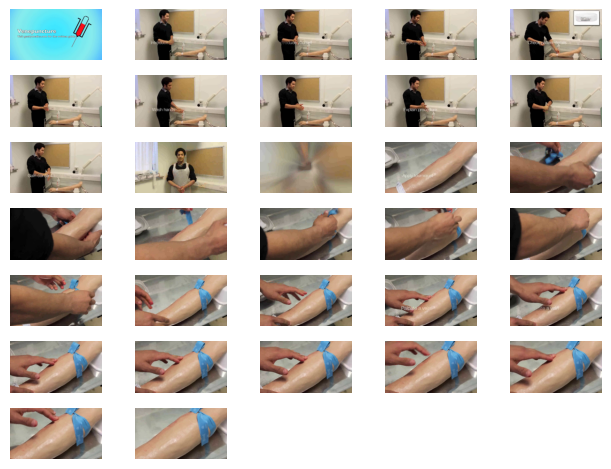

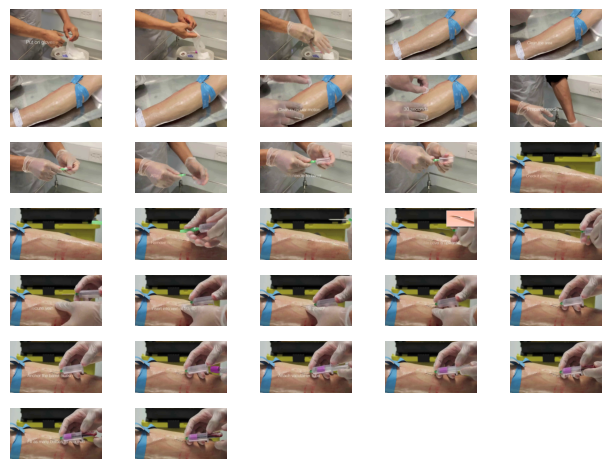

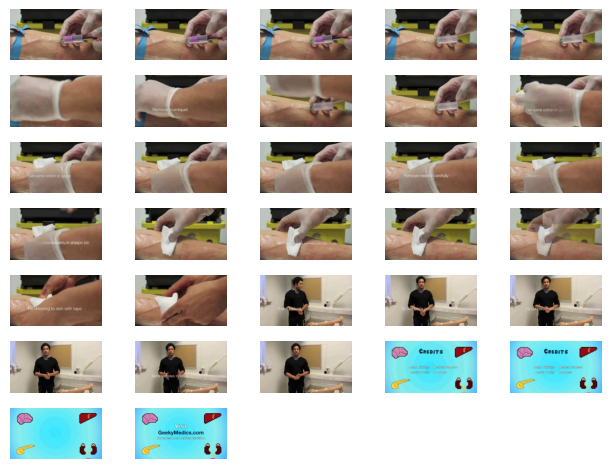

In [11]:
import os

#hotdog original pipeline:
# summary_path = "segmented_videos_slc/hotdog/segmentsummary.txt"

# woundpack pipeline:
# summary_path = "segmented_videos/woundpack/segmentsummary.txt"

# segmented_videos_highlights/takeblood:
summary_path = "segmented_videos_highlight/takeblood/segmentsummary.txt"

# segmented_videos_highlights/iv:
# summary_path = "segmented_videos_highlight/iv/segmentsummary.txt"

def process_video_segments(summary_path, output_file):
    with open(summary_path, 'r') as f:
        lines = f.readlines()

    with open(output_file, 'w') as out_f:
        for line in lines:
            if "extracted to" in line:
                parts = line.split()
                #video_path = os.path.join(video_dir, parts[-1])
                video_path = parts[-1]
                print("video path: ", video_path)
                
                # Load the video
                video, _ = load_video(
                    video_path=video_path,
                    n_frms=32,
                    sampling="uniform", return_msg=True
                )
                
                out_f.write(f"Video: {video_path}\n")
                
                C, T, H, W = video.shape
                ts.show(video.transpose(0, 1))
                
                img_list = []
                chat_state = conv_llava_llama_2.copy()
                chat_state.system =  "You are able to understand the visual content that the user provides. Follow the instructions carefully and explain your answers in detail."
                msg = chat.upload_video_without_audio(
                    video_path=video_path, 
                    conv=chat_state,
                    img_list=img_list, 
                    n_frms=96,
                )

                cooking_input = "You are given a short segment from a cooking video. Localize the key activity in the video to a start and end time. Include a short sentence to describe the  activity. The format should be: 'start time - end time, brief step description'. For example, ' 90 - 102 seconds, spread margarine on two slices of white bread'."
                med_input = "You are given a short segment from a medical procedural video. Localize the key activity in the video to a start and end time. Include a short sentence to describe the activity. The format should be: 'start time - end time, brief step description'. For example, ' 90 - 102 seconds, spread margarine on two slices of white bread'."
                med_input2 = "You are given a short segment from a medical procedural video. Localize the key event in the video to a concise start and end time. Include a sentence to describe the event. The format should be: 'start time - end time, brief step description'. For example, ' 90 - 102 seconds, spread margarine on two slices of white bread'."
                med_input3 = "You are given a short segment from a medical procedural video. Determine the start and end time of the main activity or event in the video. You must also provide a description of the event. The format should be: 'start time - end time, brief step description'. For example, ' 90 - 102 seconds, spread margarine on two slices of white bread'."
                med_input4 = "You are given a short segment from a medical procedural video. Provide a description of the main activity or event in the video."
                print(med_input4)

                chat.ask(med_input4, chat_state)

                num_beams = args.num_beams
                temperature = args.temperature
                llm_message = chat.answer(conv=chat_state,
                                          img_list=img_list,
                                          num_beams=num_beams,
                                          temperature=temperature,
                                          max_new_tokens=300,
                                          max_length=2000)[0]

                print(llm_message)
                out_f.write(f"{llm_message}\n\n")

output_file = "finegrained_outputs/finegrained_segments_takeblood_highlight_m4.txt"
process_video_segments(summary_path, output_file)

In [7]:
%pip install ffmpeg-python

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os

finegrained_file = "finegrained_outputs/finegrained_segments_iv_highlight.txt"
output_folder = "examples/iv_highlight"

def create_video_segments(finegrained_file, output_folder):
    with open(finegrained_file, 'r') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        if line.startswith("Video:"):
            video_path = line.split(":")[1].strip()
        elif "happens in" in line:
            start, end = line.split("happens in")[1].split("-")
            start = float(start.strip().split()[0])
            end = float(end.strip().split()[0])

            source_video = video_path.strip()
            output_file = os.path.join(output_folder, f"segment_{i}.mp4")
            cmd = f"ffmpeg -i {source_video} -ss {start} -to {end} -c copy {output_file}"
            os.system(cmd)

create_video_segments(finegrained_file, output_folder)


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

In [11]:
import os

def concatenate_mp4_files(input_dir, output_file):
    # Get a list of all MP4 files in the input directory
    input_files = [file for file in os.listdir(input_dir) if file.endswith('.mp4')]
    
    if not input_files:
        print("No MP4 files found in the input directory")
        return
    
    # Create a text file containing the file names of the MP4 files in the order you want to concatenate them
    with open('files.txt', 'w') as f:
        for file in input_files:
            f.write(f"file '{os.path.join(input_dir, file)}'\n")
    
    # Concatenate the MP4 files using ffmpeg
    os.system(f"ffmpeg -f concat -safe 0 -i files.txt -c copy {output_file}")
    
    # Remove the temporary text file
    os.remove('files.txt')

# Example usage:
input_dir = 'examples/iv_highlight/'
output_file = 'examples/iv_highlight/combined_video_iv_highlight.mp4'

concatenate_mp4_files(input_dir, output_file)

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

Go through the finegrained_segements.txt file and create mp4 videos from the source_video based on the time stamps provided for each segment. Create these videos in the specified folder.

format of finegrained_segments.txt:

Video: segmented_videos_slc/hotdog/output_0.mp4
The given query happens in 4.8 - 12.3 seconds.

Video: segmented_videos_slc/hotdog/output_1.mp4
The given query happens in 2.0 - 11.0 seconds.

Video: segmented_videos_slc/hotdog/output_2.mp4
The given query happens in 6.0 - 38.0 seconds.

Video: segmented_videos_slc/hotdog/output_3.mp4
The given query happens in 2.6 - 12.1 seconds.

Video: segmented_videos_slc/hotdog/output_4.mp4
The given query happens in 7.0 - 22.0 seconds.

Video: segmented_videos_slc/hotdog/output_5.mp4
The given query happens in 23.0 - 33.0 seconds.

Video: segmented_videos_slc/hotdog/output_6.mp4
The given query happens in 10.0 - 32.0 seconds.

Video: segmented_videos_slc/hotdog/output_7.mp4
The given query happens in 8.0 - 17.0 seconds.

finegrained_file = "finegrained_segments.txt"
source_video = "examples/hotdog.mp4"
output_folder = "examples/hotdog"